In [216]:
import pickle

import pandas as pd
from scipy.stats import t
import numpy as np
from utils import compute_flatness, compute_local_lipschitz, compute_condition_number
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler

In [187]:
def calculate_t_statistic(data1, data2):
    n1 = len(data1)
    n2 = len(data2)
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    std1 = np.std(data1)
    std2 = np.std(data2)

    t_stat = (mean1 - mean2) / np.sqrt((std1**2)/n1 + (std2**2)/n2)
    return t_stat

def calculate_degrees_of_freedom(data1, data2):
    n1 = len(data1)
    n2 = len(data2)
    var1 = np.var(data1, ddof=1)
    var2 = np.var(data2, ddof=1)

    numerator = (var1/n1 + var2/n2)**2
    denominator = (var1**2) / (n1**2 * (n1 - 1)) + (var2**2) / (n2**2 * (n2 - 1))
    df = numerator / denominator
    return df

def calculate_p_value(t_stat, df):
    p_value = (1 - t.cdf(abs(t_stat), df)) * 2
    return p_value

def compute_condition_number(fisher_matrix, eps_ratio=1e-12):
    # Fisher matrix의 eigenvalue들을 계산 (실수부만 사용)
    eigenvalues = torch.linalg.eigvals(fisher_matrix).real.abs()

    max_eig = eigenvalues.max().item()
    # 상대적 threshold 설정
    threshold = eps_ratio * max_eig
    min_eig = eigenvalues.min().item()

    # 만약 최소 eigenvalue가 threshold보다 작으면 threshold로 대체
    min_eig = max(min_eig, threshold)

    condition_number = max_eig / min_eig
    return condition_number


In [118]:
with open("landscape_list.pkl", "rb") as f:
    landscape_list = pickle.load(f)

/Users/jwheo/miniconda3/envs/Neural-Quantum-Embedding/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.By

In [119]:
with open("tmp_goodbad.pkl", "rb") as f:
    goodbad = pickle.load(f)

In [120]:
landscape_list

{0: {'random_circuit': [['RZ_arctan', 1, 2, 1],
   ['CNOT', 2, 3, 2],
   ['RY_arctan', 0, 2, 1],
   ['RZ', 3, 1, 2],
   ['RX_arctan', 2, 1, 2],
   ['RY_arctan', 3, 2, 1],
   ['RZ_arctan', 2, 3, 2],
   ['CNOT', 2, 1, 1],
   ['RZ_arctan', 3, 0, 0],
   ['RX', 1, 3, 0],
   ['RY', 2, 0, 1],
   ['RZ', 3, 0, 0],
   ['RX', 0, 1, 2],
   ['H', 0, 2, 0],
   ['RX', 3, 1, 1]],
  'NQE_results': [[0.1684262603521347,
    0.3242280185222626,
    0.34720051288604736,
    0.297005295753479,
    0.251310795545578,
    0.31943219900131226,
    0.2772302031517029,
    0.21114426851272583,
    0.32327988743782043,
    0.2764042913913727],
   [0.10958129912614822,
    0.15162083506584167,
    0.1042889878153801,
    0.16179008781909943,
    0.09014558792114258,
    0.12909148633480072,
    0.14646030962467194,
    0.12385420501232147,
    0.13881337642669678,
    0.08737242966890335],
   [0.2947884500026703,
    0.29860636591911316,
    0.3585776090621948,
    0.3494686484336853,
    0.31681784987449646,
   

In [121]:
goodbad.keys()

dict_keys(['good_idx', 'bad_idx', 'good_means', 'bad_means', 'rerun_good', 'rerun_bad'])

In [122]:
good_idx = goodbad['good_idx']
bad_idx = goodbad['bad_idx']
good_means = goodbad['good_means']
bad_means = goodbad['bad_means']
rerun_good = goodbad['rerun_good']
rerun_bad = goodbad['rerun_bad']

In [123]:
good_means

[0.1135470224544406,
 0.11647303961217403,
 0.11817131750285625,
 0.11986980338891347,
 0.1205548138490745,
 0.12075802577393395,
 0.12464971840381622,
 0.1297087981365621,
 0.13080244104970584,
 0.13109246641397476]

In [124]:
good_idx

Index([35, 78, 51, 20, 34, 58, 31, 102, 67, 6], dtype='int64', name='landscape')

In [125]:
bad_means

[0.3421727468570073,
 0.2552763298153877,
 0.2538873851299286,
 0.2533134650439024,
 0.24858840368688107,
 0.24089080095291138,
 0.2342351774374644,
 0.2315481036901474,
 0.2295360743999481,
 0.2243735823366377]

In [127]:
rerun_good

{'35': [[0.26142269372940063,
   0.19562789797782898,
   0.21001897752285004,
   0.13341780006885529,
   0.2208343893289566,
   0.16199949383735657,
   0.22373907268047333,
   0.08479666709899902,
   0.22199231386184692,
   0.20483645796775818],
  [0.14667755365371704,
   0.18422652781009674,
   0.19398517906665802,
   0.13429871201515198,
   0.1936100572347641,
   0.15216940641403198,
   0.12444145232439041,
   0.11508874595165253,
   0.09415313601493835,
   0.09740997105836868],
  [0.055437274277210236,
   0.13159014284610748,
   0.09258773922920227,
   0.11557523906230927,
   0.09866216778755188,
   0.1752225160598755,
   0.16162240505218506,
   0.18158410489559174,
   0.0771191194653511,
   0.14618520438671112],
  [0.19950151443481445,
   0.08790449053049088,
   0.14497046172618866,
   0.1543155312538147,
   0.13942331075668335,
   0.13432319462299347,
   0.15412062406539917,
   0.19173391163349152,
   0.10877600312232971,
   0.22393745183944702],
  [0.14375586807727814,
   0.05937

In [137]:
rerun_good_mean = {}
for rg in rerun_good:
    tok = 0
    for i in rerun_good[rg]:
        tok += sum(i)
    tokk = tok/50
    rerun_good_mean[rg] = tokk

In [138]:
rerun_good_mean

{'35': 0.15000536270439624,
 '78': 0.16092937551438807,
 '51': 0.14885239563882352,
 '20': 0.15648625791072845,
 '34': 0.14528632655739784,
 '58': 0.16805409140884875,
 '31': 0.15248600147664548,
 '102': 0.14277930065989494,
 '67': 0.1869491221755743,
 '6': 0.16971243277192116}

In [143]:
rerun_bad_mean = {}
for rb in rerun_bad:
    tok = 0
    for i in rerun_bad[rb]:
        tok += sum(i)
    tokk = tok/50
    rerun_bad_mean[rb] = tokk

In [144]:
rerun_bad_mean

{'83': 0.2917455334216356,
 '100': 0.24084410399198533,
 '61': 0.38526916682720186,
 '10': 0.24741981893777848,
 '42': 0.14861438542604447,
 '37': 0.21657532319426537,
 '74': 0.16003053076565266,
 '21': 0.19136750556528567,
 '62': 0.3623984816670418,
 '17': 0.22191522464156152}

In [151]:
list(rerun_bad_mean.values())

[0.2917455334216356,
 0.24084410399198533,
 0.38526916682720186,
 0.24741981893777848,
 0.14861438542604447,
 0.21657532319426537,
 0.16003053076565266,
 0.19136750556528567,
 0.3623984816670418,
 0.22191522464156152]

In [149]:
t_stat_first = calculate_t_statistic(good_means, bad_means)
df_first = calculate_degrees_of_freedom(good_means, bad_means)
p_value_first = calculate_p_value(t_stat_first, df_first)

print(t_stat_first, df_first, p_value_first)

-12.49534680600124 9.609094846408176 2.9374930643477626e-07


In [152]:
t_stat_first = calculate_t_statistic(list(rerun_good_mean.values()), list(rerun_bad_mean.values()))
df_first = calculate_degrees_of_freedom(list(rerun_good_mean.values()), list(rerun_bad_mean.values()))
p_value_first = calculate_p_value(t_stat_first, df_first)

print(t_stat_first, df_first, p_value_first)

-3.672457888689016 9.529080599193959 0.004661721371744587


In [155]:
landscape_list[0].keys()

dict_keys(['random_circuit', 'NQE_results', 'hessian', 'flatness_metrics', 'cond_number', 'local_lipschitz', 'fisher_matrix', 'grad_norms'])

In [174]:
landscape_list[0]['fisher_matrix']

tensor([[ 1.1906e-03, -2.9704e-05,  2.4578e-03,  ...,  1.1366e-04,
          9.5882e-05,  0.0000e+00],
        [-2.9704e-05,  9.7714e-04,  1.0709e-03,  ...,  1.4472e-04,
         -8.4132e-05,  0.0000e+00],
        [ 2.4578e-03,  1.0709e-03,  7.1149e-03,  ...,  5.3228e-04,
         -1.2074e-04,  0.0000e+00],
        ...,
        [ 1.1366e-04,  1.4472e-04,  5.3228e-04,  ...,  3.2822e-04,
          4.0584e-05,  0.0000e+00],
        [ 9.5882e-05, -8.4132e-05, -1.2074e-04,  ...,  4.0584e-05,
          2.4959e-04,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

In [175]:
landscape_list[0]['hessian']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [177]:
compute_flatness(landscape_list[0]['fisher_matrix'])

{'trace': 6.281801223754883,
 'max_eigenvalue': 4.566535472869873,
 'average_eigenvalue': 0.04244460165500641}

In [178]:
compute_local_lipschitz(landscape_list[0]['fisher_matrix'])

4.566535472869873

In [179]:
compute_condition_number(landscape_list[0]['fisher_matrix'])

inf

In [180]:
landscape_list[0]['NQE_results']

[[0.1684262603521347,
  0.3242280185222626,
  0.34720051288604736,
  0.297005295753479,
  0.251310795545578,
  0.31943219900131226,
  0.2772302031517029,
  0.21114426851272583,
  0.32327988743782043,
  0.2764042913913727],
 [0.10958129912614822,
  0.15162083506584167,
  0.1042889878153801,
  0.16179008781909943,
  0.09014558792114258,
  0.12909148633480072,
  0.14646030962467194,
  0.12385420501232147,
  0.13881337642669678,
  0.08737242966890335],
 [0.2947884500026703,
  0.29860636591911316,
  0.3585776090621948,
  0.3494686484336853,
  0.31681784987449646,
  0.3490074872970581,
  0.26059800386428833,
  0.27388814091682434,
  0.23526784777641296,
  0.4723462164402008],
 [0.14572221040725708,
  0.1880689263343811,
  0.17679303884506226,
  0.0384998545050621,
  0.1900542825460434,
  0.17225898802280426,
  0.14788056910037994,
  0.15740880370140076,
  0.26684197783470154,
  0.2257760465145111],
 [0.06907138228416443,
  0.196578249335289,
  0.11835098266601562,
  0.0964471697807312,
  0.1

In [182]:
np.array(sum(landscape_list[0]['NQE_results'], [])).mean()

0.21115129172801972

In [196]:
new_landscape_list = {}
for i in landscape_list:
    ld_mean = np.array(sum(landscape_list[i]['NQE_results'], [])).mean()
    ld_std = np.array(sum(landscape_list[i]['NQE_results'], [])).std()
    ld_flat = compute_flatness(landscape_list[i]['fisher_matrix'])
    ld_lpst = compute_local_lipschitz(landscape_list[i]['fisher_matrix'])
    ld_cdn = compute_condition_number(landscape_list[i]['fisher_matrix'])

    new_landscape_list[i] = {
        # 'random_circuit': landscape_list[0]['random_circuit'],
        'mean': ld_mean,
        'ld_std': ld_std,
        'ld_trace':ld_flat['trace'],
        'ld_max_eigen':ld_flat['max_eigenvalue'],
        'ld_avg_eigen':ld_flat['average_eigenvalue'],
        'ld_lpst':ld_lpst,
        'ld_cdn':ld_cdn,
    }

In [197]:
new_landscape_list

{0: {'mean': 0.21115129172801972,
  'ld_std': 0.09118924115603108,
  'ld_trace': 6.281801223754883,
  'ld_max_eigen': 4.566535472869873,
  'ld_avg_eigen': 0.04244460165500641,
  'ld_lpst': 4.566535472869873,
  'ld_cdn': 1000000000000.0},
 1: {'mean': 0.1459502875059843,
  'ld_std': 0.04441229394329843,
  'ld_trace': 1.901545763015747,
  'ld_max_eigen': 1.196253776550293,
  'ld_avg_eigen': 0.012848282232880592,
  'ld_lpst': 1.196253776550293,
  'ld_cdn': 1000000000000.0},
 2: {'mean': 0.16815948307514192,
  'ld_std': 0.0620252973042077,
  'ld_trace': 4.07806921005249,
  'ld_max_eigen': 1.8921613693237305,
  'ld_avg_eigen': 0.027554521337151527,
  'ld_lpst': 1.8921613693237305,
  'ld_cdn': 999999999999.9999},
 3: {'mean': 0.18842252865433692,
  'ld_std': 0.06813191977155166,
  'ld_trace': 5.608117580413818,
  'ld_max_eigen': 3.5042686462402344,
  'ld_avg_eigen': 0.03789268806576729,
  'ld_lpst': 3.5042686462402344,
  'ld_cdn': 1000000000000.0},
 4: {'mean': 0.15115397453308105,
  'ld_std

In [218]:
landscape_df = pd.DataFrame.from_dict(new_landscape_list, orient="index")

In [219]:
landscape_df

,mean,ld_std,ld_trace,ld_max_eigen,ld_avg_eigen,ld_lpst,ld_cdn
0,0.211151,0.091189,6.281801,4.566535,0.042445,4.566535,1.000000e+12
1,0.145950,0.044412,1.901546,1.196254,0.012848,1.196254,1.000000e+12
2,0.168159,0.062025,4.078069,1.892161,0.027555,1.892161,1.000000e+12
3,0.188423,0.068132,5.608118,3.504269,0.037893,3.504269,1.000000e+12
4,0.151154,0.048138,9.118379,5.460623,0.061611,5.460623,1.000000e+12
...,...,...,...,...,...,...,...
106,0.142953,0.051668,6.898725,3.301599,0.046613,3.301599,1.000000e+12
107,0.190589,0.089291,5.428710,2.936204,0.036680,2.936204,1.000000e+12
108,0.185115,0.073303,8.249735,5.189123,0.055741,5.189123,1.000000e+12
109,0.183806,0.098450,2.276098,1.639381,0.015379,1.639381,1.000000e+12


In [220]:
df_sorted = landscape_df.sort_values(by="mean", ascending=False)

In [221]:
df_sorted

,mean,ld_std,ld_trace,ld_max_eigen,ld_avg_eigen,ld_lpst,ld_cdn
61,0.311254,0.176582,3.150644,2.163716,0.021288,2.163716,1.000000e+12
83,0.309710,0.126971,3.987446,3.053701,0.026942,3.053701,1.000000e+12
62,0.274601,0.124495,1.769648,1.227462,0.011957,1.227462,1.000000e+12
68,0.268767,0.161051,2.931370,1.882336,0.019807,1.882336,1.000000e+12
42,0.266547,0.095489,2.602549,1.475237,0.017585,1.475237,1.000000e+12
...,...,...,...,...,...,...,...
20,0.131233,0.046001,10.481425,5.531760,0.070820,5.531760,1.000000e+12
58,0.130637,0.056008,3.165309,1.744459,0.021387,1.744459,1.000000e+12
44,0.130149,0.043486,9.933209,7.350800,0.067116,7.350800,1.000000e+12
51,0.127442,0.052749,6.373646,2.711135,0.043065,2.711135,1.000000e+12


In [230]:
df_scaled[['mean', 'ld_trace', 'ld_max_eigen', 'ld_avg_eigen', 'ld_lpst', 'ld_cdn']]

,mean,ld_trace,ld_max_eigen,ld_avg_eigen,ld_lpst,ld_cdn
0,3.193739,-0.786268,-0.475218,-0.786268,-0.475218,-0.000122
1,3.155498,-0.427314,0.143616,-0.427314,0.143616,0.000000
2,2.285752,-1.378659,-1.126226,-1.378659,-1.126226,0.000000
3,2.141214,-0.880327,-0.670871,-0.880327,-0.670871,0.000122
4,2.086218,-1.021378,-0.953940,-1.021378,-0.953940,0.000000
...,...,...,...,...,...,...
106,-1.265892,2.358338,1.866688,2.358339,1.866688,0.000122
107,-1.280667,-0.779977,-0.766741,-0.779977,-0.766741,0.000000
108,-1.292755,2.123176,3.131523,2.123176,3.131523,0.000000
109,-1.359814,0.596269,-0.094581,0.596269,-0.094581,0.000000


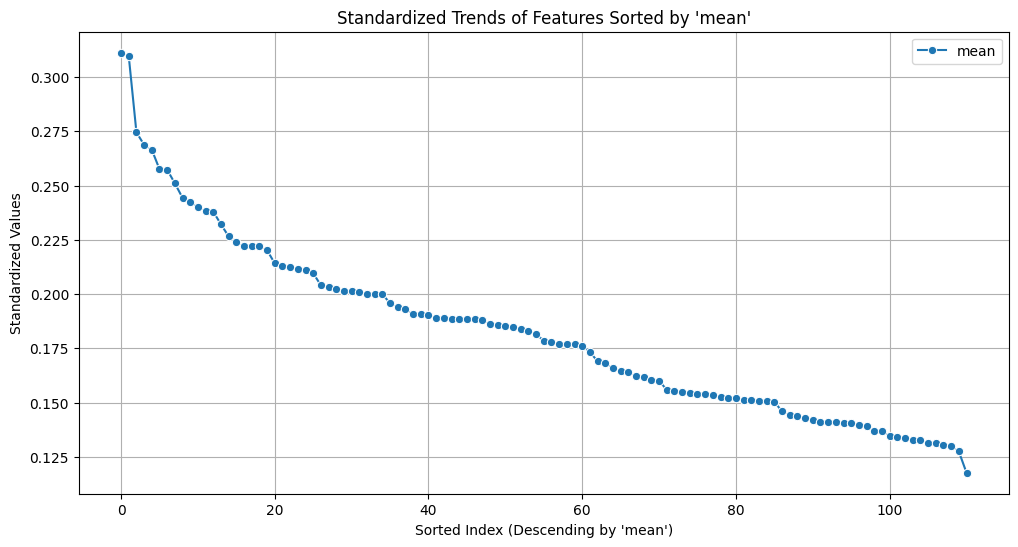

In [234]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_sorted), columns=df_sorted.columns)

# mean을 기준으로 정렬한 데이터의 인덱스를 다시 0부터 순차적으로 변경
df_sorted.reset_index(drop=True, inplace=True)
tmp = df_sorted[['mean',]]

# 그래프 그리기
plt.figure(figsize=(12, 6))
sns.lineplot(data=tmp, markers=True)
plt.title("Standardized Trends of Features Sorted by 'mean'")
plt.xlabel("Sorted Index (Descending by 'mean')")
plt.ylabel("Standardized Values")
plt.legend(tmp.columns)
plt.grid(True)
plt.show()

In [222]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_sorted), columns=df_sorted.columns)

fig = px.line(df_scaled, markers=True, title="Standardized Trends of Features Sorted by 'mean'")

# 축 레이블 설정
fig.update_layout(
    xaxis_title="Sorted Index (Descending by 'mean')",
    yaxis_title="Standardized Values",
    legend_title="Features",
    template="plotly_white"
)

# 그래프 표시
fig.show()

/var/folders/j2/p6vmvrcs1kg7j9c8811510sc0000gn/T/ipykernel_75870/1338268146.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm")


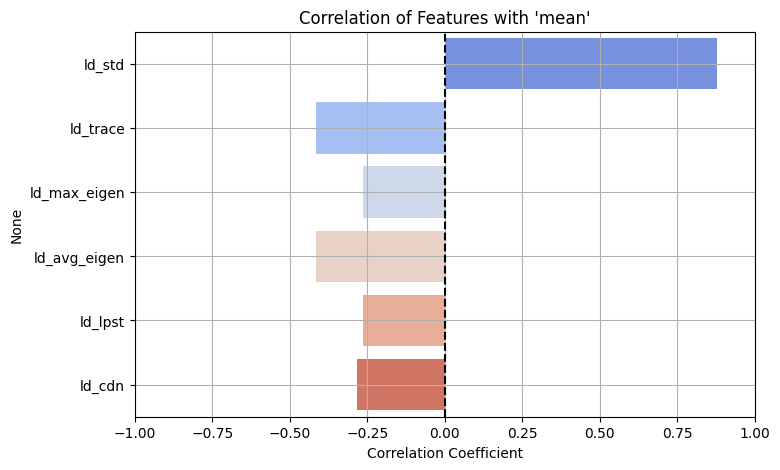

In [214]:
correlations = df_sorted.corr()["mean"].drop("mean")  # mean과의 상관관계만 추출

# 상관관계 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm")
plt.title("Correlation of Features with 'mean'")
plt.xlabel("Correlation Coefficient")
plt.xlim(-1, 1)
plt.axvline(0, color="black", linestyle="--")
plt.grid(True)

# 그래프 출력
plt.show()

In [232]:
correlations.values

array([ 0.87930025, -0.41716176, -0.26416905, -0.41716176, -0.26416905,
       -0.28253137])